### Hopefully building up a little library of things. Not really sure how well they work though...

In [1]:
import numpy as np
from sage.modules.misc import gram_schmidt

In [2]:
def uniform_rand_vec(dimension):
    """
    Makes a uniformly random vector.
    
    Args:
    - Desired dimension
    
    Returns:
    - Uniformly random vector of that dimension 
    """
    xs = np.random.normal(0,1,dimension) #normally random x's
    norm = sum(xs**2)**0.5 #and then normalize
    return vector(xs/norm)

#####################################################################################

def flat_vec(dim):
    """
    Makes a flat vector.
    
    Args:
    - Desired dimension
    
    Returns:
    - Vector of that dimension with entries of modulus 1
    """
    theta = np.random.uniform(0,2*pi,dim)    
    vec = []
    for j in range(dim):
        vec.append(math.sin(theta[j])+math.cos(theta[j])*I)

    return vec

In [150]:
def degen_find_min(G1):
    """
    Finds the degeneracy of a given graph by plucking off minimum degree vertices,
    and placing them at the end of the optimal ordering
    
    Args:
    - The graph
    
    Returns:
    - Degeneracy of the graph
    - Ordering of vertices that admits that degeneracy
    """
    ### Finding the optimal ordering ###
    G=G1.copy()
    n = len(G.vertices());
    ordering = [None for i in range(n)];
    j = 0; #counts how many vertices we've deleted so far

    while j < n:
        degs = G.degree(i for i in G.vertices()) #degrees of all vertices in graph
        mind = min(degs); #mininum degree
        for k in G.vertices():
            if G.degree(k) == mind:
                ordering[n-1-j] = k; #if the vertex has min degree, put it at end of ordering
                G.delete_vertex(k); #and remove that vertex from the graph
                j = j+1
                break
    
    ### Finding the degeneracy of that ordering###
    npnv=[] #empty list of the number of previous neighbors
    
    for i in range(n):
        vi = ordering[i] #the vertex associated with index i in the optimal ordering
        npn=0 #number of previous neighbors to vertex vi
        for j in range(i): #for all previous vertices in the optimal ordering
            vj = ordering[j]
            if vj in G1.neighbors(vi): #if the vertex is adjacent to vertex vi, increase the number of previous neighbors of i
                npn+=1
        npnv.append(npn) #put the number of vi's previous neighbors into the list of number of previous neighbors
    degen = max(npnv) #the degeneracy is the max of all of those previous neighbors
    
    return ordering,degen

#####################################################################################

def degen_find_max(G1):
    """
    Finds the degeneracy of a given graph by ordering the vertices from highest to lowest degree for the optimal ordering
    
    Args:
    - The graph
    
    Returns:
    - Degeneracy of the graph
    - Ordering of vertices that admits that degeneracy
    """
    
    ### Finding the optimal ordering ###
    G=G1.copy()
    n = len(G.vertices());
    ordering=[];
    j = 0; #counts how many vertices we've deleted so far
    degs = G.degree(i for i in G.vertices()) #degrees of all vertices in graph
    
    while j < n:
        maxd=max(degs)
        for k in G.vertices():
            if G1.degree(k) == maxd:
                ordering.append(k)
                degs.remove(maxd)
                G.delete_vertex(k)
                j=j+1
                break
            
    ### Finding the degeneracy of that ordering###
    npnv=[] #empty list of the number of previous neighbors
    for i in range(n):
        vi = ordering[i] #the vertex associated with index i in the optimal ordering
        npn=0 #number of previous neighbors to vertex vi
        for j in range(i): #for all previous vertices in the optimal ordering
            vj = ordering[j]
            if vj in G1.neighbors(vi): #if the vertex is adjacent to vertex vi, increase the number of previous neighbors of i
                npn+=1
        npnv.append(npn) #put the number of vi's previous neighbors into the list of number of previous neighbors
    degen = max(npnv) #the degeneracy is the max of all of those previous neighbors

    return ordering,degen

#####################################################################################
#####################################################################################

def modified_LSS(G,Vorder,d):
    """
    Finds an orthogonal representation of the graph
    
    Args:
    - The graph
    - An ordering of the vertices
    - Desired dimension of the orthogonal representation
    
    Returns:
    - An orthogonal representation of the graph
    """
    
    n = len(Vorder) #number of vertices
    us = [None for i in range(n)] #empty list in which we can put uniformly random vectors
    fs=[] #empty list into which we shall put orthogonal vectors

    for i in range(n): # assign uniformly random vectors to everything
        us[i] = vector(uniform_rand_vec(d)) 
        
    fs.append(Matrix(us[0])); #first one is just the regular random guy
 
    for i in range(1,n):
        prev_f = []; #gather the previously assigned f vectors (the orthogonal ones)
        vi = Vorder[i]; #the vertex in the ith place
        
        nnp=0; #number of neighbors previous in the list
        for j in range(i): #for all the vertices previous in the listed order
            vj = Vorder[j]; #the vertex in the jth place
            
            if vj in G.neighbors(vi): #if the previous vertex is a neighbor of this one
                nnp+=1; #add one to the count of previous neighbors
                prev_f.append(vector(fs[j])) #collect its vector in the list of previous f vectors
                bassisor,b = Matrix(prev_f).gram_schmidt() #gram schmidtify the previous f vectors into an orthogonal basis
        
        newv = Matrix(us[i]) #the new vector will be the randomly generated u and then we'll mess with it
        if nnp != 0: #if there were neighbors previous in the list
    
            for v1 in bassisor: #for all vectors in that basis of prev fs
                v1vec=Matrix(v1); #make a matrix out of it
                newv -= Matrix((newv*v1vec.T)*v1vec) #subtract the projection of u onto that vec from u
            
        fs.append(newv) #normalize and add it to the list of f vectors
    return fs

#####################################################################################



In [168]:
def quat_tophats(vec):
    """
    Makes the four tophat vectors for quaternion construction from one 4D vector
    
    Args:
    - A 4D vector
    
    Returns:
    - A list of four orthogonal projectors
    """
    
    phi0 = Matrix(vec[0])
    phi1 = Matrix([-vec[0][1],vec[0][0],-vec[0][3],vec[0][2]])
    phi2 = Matrix([-vec[0][2],vec[0][3],vec[0][0],-vec[0][1]])
    phi3 = Matrix([-vec[0][3],-vec[0][2],vec[0][1],vec[0][0]])

    #now outerproduct dotify them to make projection matrices
    proj0 = phi0.T * phi0
    proj1 = phi1.T * phi1
    proj2 = phi2.T * phi2
    proj3 = phi3.T * phi3
    
    return proj0, proj1, proj2, proj3 #tadah
    
#####################################################################################

def quat_const(vecs):
    """
    Constructs quantum coloring using quaternion construction
    
    Args:
    - List of 4D vectors in a real orthogonal representation
    
    Returns:
    - A quantum 4-coloring
    """
    
    n = len(vecs)
    qch = [];
    
    for j in range(n):
        qch.append(quat_tophats(vecs[j]/vecs[j].norm()))
    return qch
        
#####################################################################################
    
def oct_tophats(vec):
    """
    Makes the eight tophat vectors for octonion construction from one 8D vector
    
    Args:
    - An 8D vector
    
    Returns:
    - A list of eight orthogonal projectors
    """
        
    tophat=[None for i in range(8)];
    tophat[0] = Matrix([ vec[0][0],  vec[0][1],  vec[0][2],  vec[0][3],  vec[0][4],  vec[0][5],  vec[0][6],  vec[0][7] ])
    tophat[1] = Matrix([-vec[0][1],  vec[0][0], -vec[0][3],  vec[0][2], -vec[0][5],  vec[0][4],  vec[0][7], -vec[0][6] ])
    tophat[2] = Matrix([-vec[0][2],  vec[0][3],  vec[0][0], -vec[0][1], -vec[0][6], -vec[0][7],  vec[0][4],  vec[0][5] ])
    tophat[3] = Matrix([-vec[0][3], -vec[0][2],  vec[0][1],  vec[0][0], -vec[0][7],  vec[0][6], -vec[0][5],  vec[0][4] ])
    tophat[4] = Matrix([-vec[0][4],  vec[0][5],  vec[0][6],  vec[0][7],  vec[0][0], -vec[0][1], -vec[0][2], -vec[0][3] ])
    tophat[5] = Matrix([-vec[0][5], -vec[0][4],  vec[0][7], -vec[0][6],  vec[0][1],  vec[0][0],  vec[0][3], -vec[0][2] ])
    tophat[6] = Matrix([-vec[0][6], -vec[0][7], -vec[0][4],  vec[0][5],  vec[0][2], -vec[0][3],  vec[0][0],  vec[0][1] ])
    tophat[7] = Matrix([-vec[0][7],  vec[0][6], -vec[0][5], -vec[0][4],  vec[0][3],  vec[0][2], -vec[0][1],  vec[0][0] ])
    
    cowboy=[];
    for i in range(8):
        cowboy.append(tophat[i].conjugate_transpose() * tophat[i])
    
    return cowboy

#####################################################################################
def oct_const(vecs):
    """
    Constructs quantum coloring using octonion construction
    
    Args:
    - List of 8D vectors in a real orthogonal representation
    
    Returns:
    - A quantum 8-coloring
    """
        
    n=len(vecs)
    qch = [];
    for j in range(n):
         qch.append(oct_tophats(vecs[j]/vecs[j].norm()))
    return qch
    

In [164]:
def reconstructing(vecs,ordering):
    """
    Reconstructs a graph from vector adjacencies
    
    Args:
    - List of vectors
    
    Returns:
    - A graph with as many vertices as there are vectors, where vertices are adjacent if vectors are orthogonal
    """
    
    n = len(vecs) #how many vectors we have
    G_r = Graph() #empty graph
    G_r.add_vertices([i for i in range(n)]) #add vertices to the empty graph
    for i in range(n): #for all vertices
        for j in range(i+1,n):
            b=Matrix(vecs[i])*Matrix(vecs[j]).T #find the dot product of the vectors in the orthogonal representation
            if abs(b[0])<1e-9: #if that's about zero
                vi=ordering[i]; #name vi and vj as the ones in the order
                vj=ordering[j];
                G_r.add_edge([vi,vj]) #add an edge between vi and vj
    return G_r

#####################################################################################

#putting together:

def degen_OR_recon(G):
    """
    Finds degeneracy of graph and optimal vertex-ordering, constructs orthogonal representation, and reconstructs the graph
    
    Args:
    - The graph
    
    Returns:
    - A graph reconstructed from vector adjacencies
    """
    
    [ordering, degen] = degen_find_max(G)
    vecs = modified_LSS(G,ordering,degen+1)
    G_r = reconstructing(vecs,ordering)
    
    return G_r


In [195]:
def check_qch(qch,G,ordering):
    """
    Checks whether or not it's actually a quantum coloring
    
    Args:
    - Purported quantum coloring
    - The graph
    
    Returns:
    - IF FAILED, returns errors
    """
    
    n = len(qch);
    c = len(qch[0])
    d = len(qch[0][0][0])
    
    comp_errs = 0; #initialize number of completeness errors
    orth_errs = 0; #initialize number of orthogonality errors
    #checking completeness
    for vi in range(n):
        summ = sum(qch[vi]) #sum them all up
        for i in range(d):
            for j in range(d):
                if ((i == j) and (abs(summ[i,j]) >= 1+1e-5)) or ((i != j) and (abs(summ[i][j] > 1e-5))):
                    print('Failure on vertex ', G.vertices()[vi]) #if ON diagonal and NOT ~1, or OFF diagonal and NOT ~0, print where it failed
                    comp_errs +=1;

    #checking orthogonality
    #if they're different vertices and their respective qch matrices multiply to have trace not ~0, and they're adjacent
    #then print where they failed
    for i in range(n):
        vi = ordering[i]
        for j in range(i):
            vj = ordering[j];
            for ci in range(c):
                #if the vertices are different AND the trace of their product isn't zero AND they're neighbors, then it's failure
                #if ((vi != vj) and (abs((qch[vi][ci]*qch[vj][ci].conjugate_transpose()).trace()) > 1e-5) and (G.vertices()[vi] in G.neighbors(G.vertices()[vj]))):
                #if (  abs( (qch[i][ci]*qch[j][ci].conjugate_transpose() ).trace() ) > 1e-5  ) and ( vi in G.neighbors(vj)):
                vjMAT = qch[j][ci]
                viMAT = qch[i][ci]
                thetrace = (vjMAT*viMAT).trace()
                if (vi in G.neighbors(vj)) and (abs(thetrace) > 1e-5) :
                    print('Failure on vertices ', G.vertices()[vi], G.vertices()[vj],' on color ',ci)
                    print('With trace of ', thetrace)
                    #print('With trace of ',((qch[vi][ci]*qch[vj][ci].conjugate_transpose()).trace()))
                    #print('And matrices of ',((qch[vi][ci]*qch[vj][ci].conjugate_transpose())))
                    orth_errs +=1;
    
    if ((comp_errs == 0) and (orth_errs == 0)):
        print('All quiet on the errors front')
    else:
        print('Wow, whoops!\nCompleteness errors:', comp_errs,'\nOrthogonality errors: ',orth_errs)

    return


All quiet on the errors front
[0, 2, 3, 4, 1, 5]


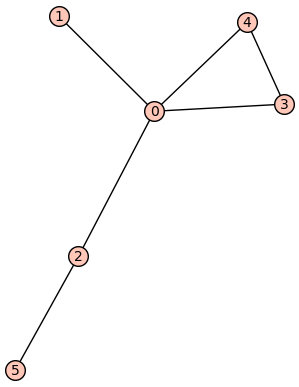

True

In [199]:
G= Graph() #define a graph
G.add_vertices([i for i in range(6)]) #add 6 vertices
G.add_edges([(0,1),(0,2),(0,3),(0,4),(3,4),(2,5)]) #add edges
[ordering, degen] = degen_find_max(G)
vecs=modified_LSS(G,ordering,8)
reconstructing(vecs,ordering)

qch=oct_const(vecs)
check_qch(qch,G,ordering)

#(qch[3][3].conjugate_transpose()).trace()
print(ordering)
G.show()
qch[1][0]*qch[5][0].T
ordering[1] in G.neighbors(ordering[5])

In [190]:
vecs

[[-0.22027442423408672   0.8787197590012431   0.3788906595618868  -0.1891365413290016],
 [  0.5882019848923905 -0.13666792306883715   0.2878953782830617  -0.7432608592051245],
 [-0.43398149878292547  -0.3667968912974825   0.5240668362568882 -0.14884813748295705],
 [-0.04692764033163399 -0.04811978711686293   -0.279601672624848  -0.7290252320908774],
 [ 0.1535495374563363 0.18151503663412388  0.1378120831345009  0.9405560824791568],
 [-0.04568028972111151  -0.5725957137816529  -0.7807804748384295 -0.23329206446958176]]

Failure on vertices  4 3  on color  0
With trace of  0.46222472949018906
Failure on vertices  4 3  on color  1
With trace of  0.4622247294901891
Failure on vertices  4 3  on color  2
With trace of  0.462224729490189
Failure on vertices  4 3  on color  3
With trace of  0.46222472949018906
Failure on vertices  4 3  on color  4
With trace of  0.4622247294901891
Failure on vertices  4 3  on color  5
With trace of  0.462224729490189
Failure on vertices  4 3  on color  6
With trace of  0.46222472949018906
Failure on vertices  4 3  on color  7
With trace of  0.46222472949018906
Failure on vertices  5 2  on color  0
With trace of  0.23303498048312216
Failure on vertices  5 2  on color  1
With trace of  0.23303498048312216
Failure on vertices  5 2  on color  2
With trace of  0.23303498048312216
Failure on vertices  5 2  on color  3
With trace of  0.23303498048312216
Failure on vertices  5 2  on color  4
With trace of  0.23303498048312207
Failure on vertices  5 2  on color  5
With trace of  0.23

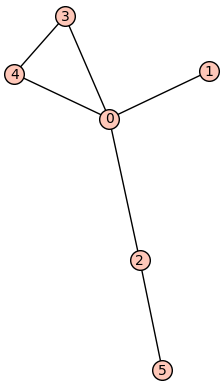

[-1.3183898417423734e-16]

In [ ]:
G= Graph() #define a graph
G.add_vertices([i for i in range(6)]) #add 6 vertices
G.add_edges([(0,1),(0,2),(0,3),(0,4),(3,4),(2,5)]) #add edges
[ordering, degen] = degen_find_max(G)
vecs=modified_LSS(G,ordering,8)
reconstructing(vecs,ordering)

qch=oct_const(vecs)
check_qch(qch,G)

#(qch[3][3].conjugate_transpose()).trace()
print(ordering)
G.show()
vecs[1]*vecs[5].T

In [36]:
def halve_qcoloring(qch):
    """
    Cuts an 8D quantum 8-coloring down into being a 4D quantum 8-coloring

    Args:
    - An 8D quantum 8-coloring

    Returns:
    - A 4D quantum 8-coloring
    """
    
    n = len(qch);
    c = len(qch[0]);
    dhalf = len(qch[0][0][0])/2;
    hqch = [] #empty list for when we halve it
    
    for vi in range(n):
        listofmats = []; #empty list of halved matrices for this vertex
        for ci in range(c):
            #ignore the fact that I don't know how to use Sage and thus had to make a silly ass matrix
            #empt = Matrix([math.pi, math.pi, math.pi, math.pi]).T*Matrix([math.pi, math.pi, math.pi, math.pi])
            empt = Matrix(QQ,dhalf,dhalf,range(dhalf*dhalf))
            for i in range(dhalf):
                for j in range(dhalf):
                    empt[i,j] = qch[vi][ci][i][j]
            listofmats.append(empt)
        hqch.append(listofmats)

    return hqch


        

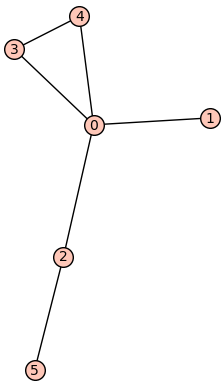

In [ ]:
G.show()

In [77]:
hqch = halve_qcoloring(qch)
#qch[0][0][0][0]
hqch
#qch
#check_qch(hqch,G)

#len(hqch[0][0][0])

check_qch(halve_qcoloring(halve_qcoloring(hqch)),G)
bees=halve_qcoloring(halve_qcoloring(hqch))
#float(bees[0][0][0][0])

float(((bees[0][0]*bees[1][0].conjugate_transpose())).trace())


TypeError: unhashable type: 'list'

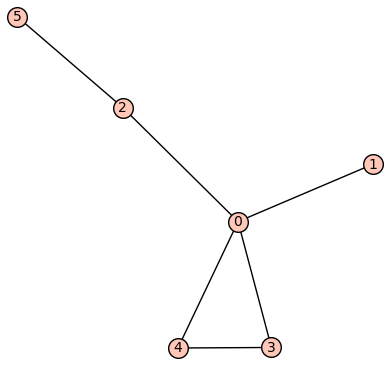

In [65]:
G.show()

In [9]:
G = graphs.CirculantGraph(7,[1,2])
# G_r=degen_OR_recon(G)
# G.is_isomorphic(G_r)
[ordering, degen] = degen_find_max(G)
vecs=modified_LSS(G,ordering,8)
# oct_tophats(vecs)
oct_tophats(vecs[0])

[
[   0.42058702528158487    0.01599157144786023    0.20304804579535637   -0.19180132830123836  -0.060883017096617704    -0.2850989584139372     0.1770020899331534    -0.2215935309285106]  [0.0006080319696044024  -0.01599157144786023 -0.007292675382152465 -0.007720298384171311 -0.010840040441415467 0.0023148957512657896  0.008425435330189818  0.006729978333714752]  [  0.09802610737625696    0.0925964962101393  -0.20304804579535637  0.007720298384171311    0.0854518240037452     -0.10697936624603   0.02939267476289114   0.13763806985126256]  [   0.08746762816444437    -0.0925964962101393   0.007292675382152465    0.19180132830123836    0.10105383908739138    0.08071869534859025    0.13001437427719648   -0.02776463097571824]  [  0.008813257537617487  -0.041270138439773764    0.02562233407062993   -0.03207726801127049   0.060883017096617704 -0.0023148957512657896   -0.02939267476289114    0.02776463097571824]  [   0.1932570697688394  0.041270138439773764  -0.15020930523638545  -0.11998256